In [ ]:
''' This notebook is authored by Shashwat Bhardwaj'''

# Pucho Deep Learning Intern Assignment
<br>
Shashwat Bhardwaj<br>
B.Tech : Computer Science and Engineering<br>
VI Semester<br>
Mahraja Agrasen Institute of Technology<br>
New Delhi, India<br><br><br><br>


PS: I have also attached my resume with this notebook<br>

# Sentiment & Semantic Analysis on IMDB Dataset 

This notebook is aimed at using Recurrent Neural Network architectures like GRU(s): Gated Recurrent Units and LSTM(s): Long Short Term Memory which is a special case of GRU, to contrast the working & accuracies between the two and to project their working domains. This is a kaggle challenge Bag of Words Meets Bags of Popcorn. Basic goal of the challenge is to predict sentiments from the given reviews about movies. The dataset from IMDB is used for training of the neural network.

### Libraries used in this notebook

###### General Purpose Libraries: <br>

- numpy: for Linear Algebra
- pandas: for csv loading of files
- bs4: Beautiful soap for scrapping related tasks
- pickle: used for serializing and de-serializing a Python object structure. Any object in Python can be pickled so that it can be saved on disk.
- os: used for directory related and os related tasks
- re: used for incorporating regular expressions in python
- lxml: used as a support for bs4 to work. It's a xml parser, used for parsing XML pages
- html: used as a support for bs4 to work. It's a html parser, used for parsing HTML pages
- matplotlib: used for plotting graphs
- sklearn: for model evaluation tasks
<br>

###### Special purpose and deep learning libraries:<br>

- nltk: Natural Language Toolkit. Used for NLP related tasks like stemming etc.
- keras: A high level API of tensorflow used for fast development of neural network and deep neural model architectures.

### Steps used:  <br>
- Importing libraries
- Loading data
- Exploring the data
- Defining preprocessing functions
- Data-Preprocessing step
- Generaing text sequence for RNN model
- Defining RNN model
- Implementing GRU
- Implementing LSTM
- Evaluation of models

## Importing Libraries <br>
We import the libraries

In [1]:
import numpy as np 
import pandas as pd 
from bs4 import BeautifulSoup
import pickle
import os, re
from nltk.corpus import stopwords
import lxml
import html

## Loading data

We load the training and the test sets

In [2]:
train = pd.read_csv("labeledTrainData.tsv", header = 0, delimiter = '\t')
test = pd.read_csv("testData.tsv", header = 0, delimiter = '\t')

## Exploring the dataset

In this section we explore our dataset and gain useful insights from it. This is a very crucial step in any deep learning project and action. As all machine and deep learning is about data, the primary and the most crucial part of any ML and DL development is having a strong knowledge of the data to be operated on.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


We can infer from the above data that:
- It has 25000 entries
- It has 3 columns named id, sentiment and review


Now let us see first ten rows of our data

In [4]:
train.head(n=10)

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
5,8196_8,1,I dont know why people think this is such a ba...
6,7166_2,0,"This movie could have been very good, but come..."
7,10633_1,0,I watched this video at a friend's house. I'm ...
8,319_1,0,"A friend of mine bought this film for £1, and ..."
9,8713_10,1,<br /><br />This movie is full of references. ...


Now let us see read a few reviews

In [36]:
# Seeing the review
print(train['review'][0],'\n')
print(train['review'][23],'\n')
print(train['review'][456])

With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally star

Let's see the length and datatype of these reviews

In [37]:
print(len(train['review'][0]))
print(len(train['review'][23]))
print(len(train['review'][456]))

2302
221
266


In [38]:
print(type(train['review'][0]))
print(type(train['review'][23]))
print(type(train['review'][456]))

<class 'str'>
<class 'str'>
<class 'str'>


These reviews are of type String

Here we do a little preprocessing first. For the sentiment column, we map it with 1 if after seperating words which have ' _ ' in between , if their length greater than 5, basically a dummy review.

In [8]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test = test["sentiment"]

In [50]:
# x="My name is Tony_Stark and I am the greatest_avenger earth has_ever_seen"
# ans=x.strip('"').split("_")
# print(ans)
# print(ans[1])
# b= lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0
# print(b)
# print(x)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


## Some Preprocessing Functions

Now basically we are creating a final dataset which can be fed to the neural network. So we create some preprocessing helper functions for us. These functions basically help in extracting out the real and actual fleshy content from the dataset, by usage of regular expressions and all to eliminate all the irrevelant data like html tags and all.

Basic Preprocessing Helper functions used are:

- html_to_text: This function converts a html document or an xml file to text by eliminating all html tags and xml tags. For this we use BeautifulSoup library.

- letters_only: This function returns the inpit strings as just pieces of plain texts without any puntuation marks or numbers

- rnn_tokenizer_review_preprocess: This function is used before fitting/transforming RNN tokenizer to convert Html to text and remove punctuations

- get_train_val_data: Extracts features (using reviews_to_features_fn), splits into train/test data, and returns x_train, y_train, x_test, y_test.  If no feature extraction function is provided, x_train/x_test will simply consist of a Series of all the reviews.


In [10]:
def html_to_text(review):
    """Return extracted text string from provided HTML string."""
    review_text = BeautifulSoup(review, "lxml").get_text()
    if len(review_text) == 0:
        review_text = review
    review_text = re.sub(r"\<.*\>", "", review_text)
    try:
        review_text = review_text.encode('ascii', 'ignore').decode('ascii')#ignore \xc3 etc.
    except UnicodeDecodeError:
        review_text = review_text.decode("ascii", "ignore")
    return review_text


def letters_only(text):
    """Return input string with only letters (no punctuation, no numbers)."""
    # It is probably worth experimenting with milder prepreocessing (eg just removing punctuation)
    return re.sub("[^a-zA-Z]", " ", text)

def rnn_tokenizer_review_preprocess(review):
    """Preprocessing used before fitting/transforming RNN tokenizer - Html->text, remove punctuation/#s, lowercase."""
    return letters_only(html_to_text(review)).lower()

In [53]:
def get_train_val_data(reviews_to_features_fn=None, df = train):
    """Extracts features (using reviews_to_features_fn), splits into train/test data, and returns
    x_train, y_train, x_test, y_test.  If no feature extraction function is provided, x_train/x_test will
    simply consist of a Series of all the reviews.
    """

    SEED = 1000
    # Shuffle data frame rows
    np.random.seed(SEED)
    
    # We also ensure permuations randomly !!
    
    print(df)
    df = df.iloc[np.random.permutation(len(df))]

    if reviews_to_features_fn:
        feature_rows = df["review"].map(reviews_to_features_fn)
        if type(feature_rows[0]) == np.ndarray:
            num_instances = len(feature_rows)
            num_features = len(feature_rows[0])
            x = np.concatenate(feature_rows.values).reshape((num_instances, num_features))
        else:
            x = feature_rows
    else:
        x = df["review"]

    y = df["sentiment"]

    # Split 80/20
    test_start_index = int(df.shape[0] * .8)
    x_train = x[0:test_start_index]
    y_train = y[0:test_start_index]
    x_val = x[test_start_index:]
    y_val = y[test_start_index:]

    return x_train, y_train, x_val, y_val

## Preprocessing of data

In [54]:
x_train, y_train, x_val, y_val = get_train_val_data(rnn_tokenizer_review_preprocess)
x_test = test["review"].map(rnn_tokenizer_review_preprocess)
y_test = test["sentiment"]

            id  sentiment                                             review
0       5814_8          1  With all this stuff going down at the moment w...
1       2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2       7759_3          0  The film starts with a manager (Nicholas Bell)...
3       3630_4          0  It must be assumed that those who praised this...
4       9495_8          1  Superbly trashy and wondrously unpretentious 8...
5       8196_8          1  I dont know why people think this is such a ba...
6       7166_2          0  This movie could have been very good, but come...
7      10633_1          0  I watched this video at a friend's house. I'm ...
8        319_1          0  A friend of mine bought this film for £1, and ...
9      8713_10          1  <br /><br />This movie is full of references. ...
10      2486_3          0  What happens when an army of wetbacks, towelhe...
11     6811_10          1  Although I generally do not like remakes belie...

Let's see our final X-train

In [51]:
x_train

array([[   0,    0,    0, ...,   41,   28, 2777],
       [   0,    0,    0, ..., 3088,  128,   56],
       [   0,    0,    0, ...,    3,  664, 2406],
       ...,
       [   0,    0,    0, ...,   21,  121,    7],
       [   0,    0,    0, ...,   10,   13,   29],
       [   0,    0,    0, ...,    3,   49,   19]])

## Generate the text sequence for RNN model

We now generate the text sequence which is to be fed to the neural network

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


We set a seed to the random generator, so that it generates same values everytime we execute the code. We limit the most frequently used words and maximum review length to:

- Prevent overfitting
- Save computation time by reducing uncessary text analysis

In [14]:
np.random.seed(1000)
num_most_freq_words_to_include = 5000
MAX_REVIEW_LENGTH_FOR_KERAS_RNN = 500
embedding_vector_length = 32

We also convert everything into a list for easy processing

In [15]:
train_review_list = x_train.tolist()
val_review_list = x_val.tolist()
test_review_list = x_test.tolist()
all_review_list = x_train.tolist() + x_val.tolist()

Tokenizer: This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf normalization

In [16]:
tokenizer = Tokenizer(num_words=num_most_freq_words_to_include)
tokenizer.fit_on_texts(all_review_list)

Two more steps: <br>

- We must ensure all sequences are of same length
- conversion of texts to numbers

    - pad_sequences: is used to ensure that all sequences in a list have the same length. 
    - tokenizer.texts_to_sequences: Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.

In [17]:
train_reviews_tokenized = tokenizer.texts_to_sequences(train_review_list)
x_train = pad_sequences(train_reviews_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
val_review_tokenized = tokenizer.texts_to_sequences(val_review_list)
x_val = pad_sequences(val_review_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
test_review_tokenized = tokenizer.texts_to_sequences(test_review_list)
x_test = pad_sequences(test_review_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)

## RNN Architecture <br>

Its the time to define our RNN Architecture <br>


Recurrent Neural Network(RNN) is a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other, but in cases like when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer. The main and most important feature of RNN is Hidden state, which remembers some information about a sequence. RNNs have a “memory” which remember all information about what has been calculated. It uses the same parameters for each input as it performs the same task on all the inputs or hidden layers to produce the output. This reduces the complexity of parameters, unlike other neural networks.RNNs have many types but the most used are:

GRU: Gated Recurrent Unit

LSTM: Long Short Term Memory<br>

#### Training through RNN

- A single time step of the input is provided to the network.
- Then calculate its current state using set of current input and the previous state.
- The current ht becomes ht-1 for the next time step.
- One can go as many time steps according to the problem and join the information from all the previous states.
- Once all the time steps are completed the final current state is used to calculate the output.
- The output is then compared to the actual output i.e the target output and the error is generated.
- The error is then back-propagated to the network to update the weights and hence the network (RNN) is trained.<br>

#### Advantages of Recurrent Neural Network
- An RNN remembers each and every information through time. It is useful in time series prediction only because of the feature to remember previous inputs as well. This is called Long Short Term Memory.
- Recurrent neural network are even used with convolutional layers to extend the effective pixel neighborhood.<br>

#### Disadvantages of Recurrent Neural Network

- Gradient vanishing and exploding problems, solved by GRUs and LSTMs
- Training an RNN is a very difficult task.
- It cannot process very long sequences if using tanh or relu as an activation function.

In [18]:
from keras.layers import Input, Embedding, Dropout, Conv1D, MaxPool1D, GRU, LSTM, Dense
from keras.models import Model

The architectures we've used for GRU and LSTM is:
    
    - Embedding layer has max_review_length x most_freq_length_to_include dimension
    - Has 100 units 
    - Adam optimizer
    - Loss function used is Binary Cross Entropy (summation(0,m)[-ylogy_ +(1-y)log(1-y_)])
    

In [19]:
def rnn_model(use_cnn = True, use_lstm = False):
    input_sequences = Input(shape = (MAX_REVIEW_LENGTH_FOR_KERAS_RNN,))
    initial_dropout = 0.2
    embedding_layer = Embedding(input_dim = num_most_freq_words_to_include, 
                                output_dim = embedding_vector_length,
                                input_length = MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
    X = embedding_layer(input_sequences)
    X = Dropout(0.2)(X)
    if use_cnn:
        X = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(X)
        X = MaxPool1D(pool_size=2)(X)
        
    # Add GRU layers
    dropout_W = 0.0
    dropout_U = 0.0
    
    if use_lstm:
        X = LSTM(100, dropout = dropout_W, recurrent_dropout = dropout_U)(X)
    else:
        X = GRU(100, dropout=dropout_W, recurrent_dropout=dropout_U)(X)
    X = Dropout(0.2)(X)
    outputs= Dense(1, activation='sigmoid')(X)
    model = Model(inputs = input_sequences, outputs = outputs)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

RNNs have many types but the most used are:

- GRU: Gated Recurrent Unit

- LSTM: Long Short Term Memory





## GRU Model

Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory (LSTM) with forget gate but has fewer parameters than LSTM, as it lacks an output gate. GRU's performance on certain tasks of polyphonic music modeling and speech signal modeling was found to be similar to that of LSTM. GRUs have been shown to exhibit even better performance on certain smaller datasets.
GRUs were aimed to solve vanishing gradients problem.

Intialization of gru model

In [20]:
gru_model = rnn_model(use_lstm=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Let's see the final GRU constructed before training of the network

In [21]:
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               39900     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
__________

There are 203,105 parameters for the network to be trained! These is a humongous set of parameters. But we have a Nvidia GTX 1060 GPU, which would enable fast computation. So now, its time to train our network. We are using 3 epochs here for training, keeping batch size as 64.

In [22]:
gru_model.fit(x_train, y_train, batch_size=64, epochs=3, validation_data=[x_val, y_val])

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 404s 20ms/step - loss: 0.5030 - acc: 0.7262 - val_loss: 0.3105 - val_acc: 0.8748
Epoch 2/3
20000/20000 [==============================] - 1129s 56ms/step - loss: 0.2732 - acc: 0.8925 - val_loss: 0.3013 - val_acc: 0.8822
Epoch 3/3
20000/20000 [==============================] - 369s 18ms/step - loss: 0.2125 - acc: 0.9194 - val_loss: 0.2851 - val_acc: 0.8884


Now since we have our model trained, lets have predictions on the test set, to get final accuracy.

In [23]:
y_test_pred_gru = gru_model.predict(x_test)

## LSTM Model

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections that make it a "general purpose computer" (that is, it can compute anything that a Turing machine can). It can not only process single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition. Bloomberg Business Week wrote: "These powers make LSTM arguably the most commercial AI achievement, used for everything from predicting diseases to composing music."
<br>
A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.
<br>
LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the exploding and vanishing gradient problems that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications.

Intialization of LSTM model and its final construction

In [24]:
lstm_model = rnn_model(use_lstm=True)
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
__________

Its training time for our model this time using LSTM over 3 epochs, keeping batch size as 64.

In [25]:
lstm_model.fit(x_train, y_train, batch_size = 64, epochs = 3, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 162s 8ms/step - loss: 0.4683 - acc: 0.7600 - val_loss: 0.3051 - val_acc: 0.8832
Epoch 2/3
20000/20000 [==============================] - 119s 6ms/step - loss: 0.2687 - acc: 0.8934 - val_loss: 0.3002 - val_acc: 0.8764
Epoch 3/3
20000/20000 [==============================] - 116s 6ms/step - loss: 0.2185 - acc: 0.9160 - val_loss: 0.3141 - val_acc: 0.8890


Now since we have our model trained, lets have predictions on the test set, to get final accuracy.

In [26]:
y_test_pred_lstm = lstm_model.predict(x_test)

## Model Evluation

In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

Computing the accuracies of both the models on test set

In [28]:
print("The AUC socre for GRU model is : %.4f." %roc_auc_score(y_test, y_test_pred_gru))
print("The AUC socre for LSTM model is : %.4f." %roc_auc_score(y_test, y_test_pred_lstm))

The AUC socre for GRU model is : 0.9489.
The AUC socre for LSTM model is : 0.9457.


- Accuracy on GRU Model is 94.89% 
- Accuracy on LSTM model is 94.57%

Which are pretty good results !

# Visualising Results

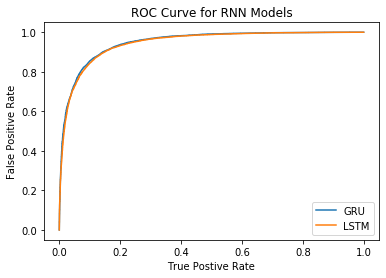

In [29]:
y_pred_list = [y_test_pred_gru, y_test_pred_lstm]
label_list = ["GRU", "LSTM"]
pred_label = zip(y_pred_list, label_list)
for y_pred, lbl in pred_label:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label = lbl)

plt.xlabel("True Postive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve for RNN Models")
plt.legend()
plt.show()